In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
set(y_train), set(y_test)

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

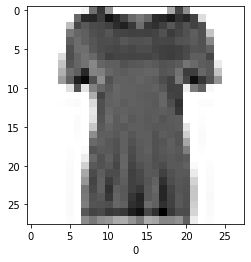

In [ ]:
plt.imshow(x_train[10], cmap = 'binary')
plt.xlabel(y_train[10])
plt.show()

In [ ]:
def create_model(hp):
  
  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers', values = [1,2,3])
    num_units = hp.Choice('num_units', values = [8, 16, 32])
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.5)
    learning_rate = hp.Float('learning_rate', min_value = 0.0001, max_value = 0.01)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape = (28,28)))
  model.add(tf.keras.layers.Lambda(lambda x: x/255.)) ## This line normalizes the input

  for _ in range(0, num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
  
  model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

  model.compile(
      loss = 'sparse_categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate  = learning_rate ),
      metrics = ['accuracy']
       
  )

  return model



In [ ]:
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class CustomTuner (keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int( 'batch_size', 32, 128, step =32)
    return super(CustomTuner, self).run_trial(trial, *args, **kwargs )
    
    
    

In [ ]:
import keras_tuner as kt

In [ ]:
tuner = CustomTuner(
    create_model,
    objective = 'val_accuracy',
    max_trials = 20,
    directory = 'logs',
    project_name = 'fashion_mnist',
    overwrite = True

)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [ ]:
tuner.search(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 5, verbose = True
)

Trial 20 Complete [00h 00m 21s]
val_accuracy: 0.8263999819755554

Best val_accuracy So Far: 0.8511000275611877
Total elapsed time: 00h 05m 48s


In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]


In [ ]:
best_hp['batch_size'], best_hp['num_hidden_layers'], best_hp['num_units'], best_hp['dropout_rate'], best_hp['learning_rate']

(64, 1, 32, 0.1, 0.005895361807578773)

In [ ]:
model = create_model(best_hp)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                25120     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
